## In this notebook

- Create U-net model.
    - Without clouds.
- Links:
    - [U-Net Image Segmentation in Keras](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)
    - [U-Net regression demo in Google Colab](https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb)
    - [fnands/BioMassters_baseline](https://github.com/fnands/BioMassters_baseline/blob/main/unet_baseline.ipynb)

In [1]:
import os
import datetime
import time

# analytics
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import numpy as np

# tif images processing
import tensorflow as tf
import tifffile as tiff
import matplotlib.pyplot as plt

# model
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

from tensorflow.keras import layers

/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/venv/lib/python3.8/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: cannot open shared object file: No such file or directory']
  warnings.warn(f"file system plugin

In [2]:
FEATURES_METADATA_PROCESSED_FILEPATH = "../data/features_metadata_processed.csv"
FILTER_MONTH = "April"
SUBMISSION_FILES_CNT = 2_773
CHIPS_TO_SELECT_CNT = 100

## Load metadata

In [3]:
df_metadata = pd.read_csv(FEATURES_METADATA_PROCESSED_FILEPATH)

# filter metadata
df_metadata = (
    df_metadata
    .loc[
        (df_metadata.month == FILTER_MONTH) &
        (df_metadata.split == "train")
    ]
    .reset_index(drop=True)
)

df_metadata.tail()

,filename,filepath,label_filename,label_filepath,chip_id,satellite,split,month
17373,ffc7d4f2_S2_07.tif,/usr/src/app/data/train_features/ffc7d4f2_S2_0...,ffc7d4f2_agbm.tif,/usr/src/app/data/train_agbm/ffc7d4f2_agbm.tif,ffc7d4f2,S2,train,April
17374,ffd8db7a_S1_07.tif,/usr/src/app/data/train_features/ffd8db7a_S1_0...,ffd8db7a_agbm.tif,/usr/src/app/data/train_agbm/ffd8db7a_agbm.tif,ffd8db7a,S1,train,April
17375,ffd8db7a_S2_07.tif,/usr/src/app/data/train_features/ffd8db7a_S2_0...,ffd8db7a_agbm.tif,/usr/src/app/data/train_agbm/ffd8db7a_agbm.tif,ffd8db7a,S2,train,April
17376,fff05995_S1_07.tif,/usr/src/app/data/train_features/fff05995_S1_0...,fff05995_agbm.tif,/usr/src/app/data/train_agbm/fff05995_agbm.tif,fff05995,S1,train,April
17377,fff05995_S2_07.tif,/usr/src/app/data/train_features/fff05995_S2_0...,fff05995_agbm.tif,/usr/src/app/data/train_agbm/fff05995_agbm.tif,fff05995,S2,train,April


## Load data

In [4]:
def is_img_cloudy(filepath: str, clouds_threshold=0.1) -> bool:
    """Decide, if satelite image is cloudy."""
    cloud_probs = (
        tf
        .transpose(
            tiff.imread(filepath), 
            perm=(2, 0, 1)
        )
        .numpy()[10]
    )

    return np.mean(cloud_probs == 255) >= clouds_threshold

In [5]:
%%time

features = []
labels = []
chips_cnt = 0

for chip_id in df_metadata.chip_id.unique():
    
    # load data only from S2 satelite
    row = (
        df_metadata
        .loc[
            (df_metadata.chip_id == chip_id) & 
            (df_metadata.satellite == "S2")
        ]        
    )
    
    # load features
    filepath = row.filepath.values[0]
    
    # if is_img_cloudy(filepath=filepath):
    #     continue

    features.append(
        tiff.imread(filepath)
    )
    
    # read labels
    label_filepath = row.label_filepath.values[0]
    labels.append(
        tiff.imread(label_filepath)
    )
    
    print(f"✅ Loaded chip with the following chip_id: {chip_id}")
    
    chips_cnt += 1
    if chips_cnt == CHIPS_TO_SELECT_CNT:
        break

✅ Loaded chip with the following chip_id: 0003d2eb
✅ Loaded chip with the following chip_id: 000aa810
✅ Loaded chip with the following chip_id: 000d7e33
✅ Loaded chip with the following chip_id: 00184691
✅ Loaded chip with the following chip_id: 001b0634
✅ Loaded chip with the following chip_id: 001eb75a
✅ Loaded chip with the following chip_id: 0029317e
✅ Loaded chip with the following chip_id: 002fb84c
✅ Loaded chip with the following chip_id: 00301627
✅ Loaded chip with the following chip_id: 003a2b5b
✅ Loaded chip with the following chip_id: 003ab939
✅ Loaded chip with the following chip_id: 0040c3a8
✅ Loaded chip with the following chip_id: 004ef4ec
✅ Loaded chip with the following chip_id: 0058fedc
✅ Loaded chip with the following chip_id: 0060c0a5
✅ Loaded chip with the following chip_id: 00635116
✅ Loaded chip with the following chip_id: 0080ae28
✅ Loaded chip with the following chip_id: 0083efdf
✅ Loaded chip with the following chip_id: 008a52a9
✅ Loaded chip with the followin

In [6]:
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
print(dataset)

<TensorSliceDataset element_spec=(TensorSpec(shape=(256, 256, 11), dtype=tf.uint16, name=None), TensorSpec(shape=(256, 256), dtype=tf.float32, name=None))>


In [7]:
BATCH_SIZE = 10
BUFFER_SIZE = 1000

# train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
# test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

train_batches = (
    dataset
    .take(CHIPS_TO_SELECT_CNT - BATCH_SIZE)
    .cache()
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
test_batches = (
    dataset
    .skip(CHIPS_TO_SELECT_CNT - BATCH_SIZE)
    .take(BATCH_SIZE)
    .batch(BATCH_SIZE)
)

In [8]:
print(train_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 11), dtype=tf.uint16, name=None), TensorSpec(shape=(None, 256, 256), dtype=tf.float32, name=None))>


2023-01-22 10:39:44.818645: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


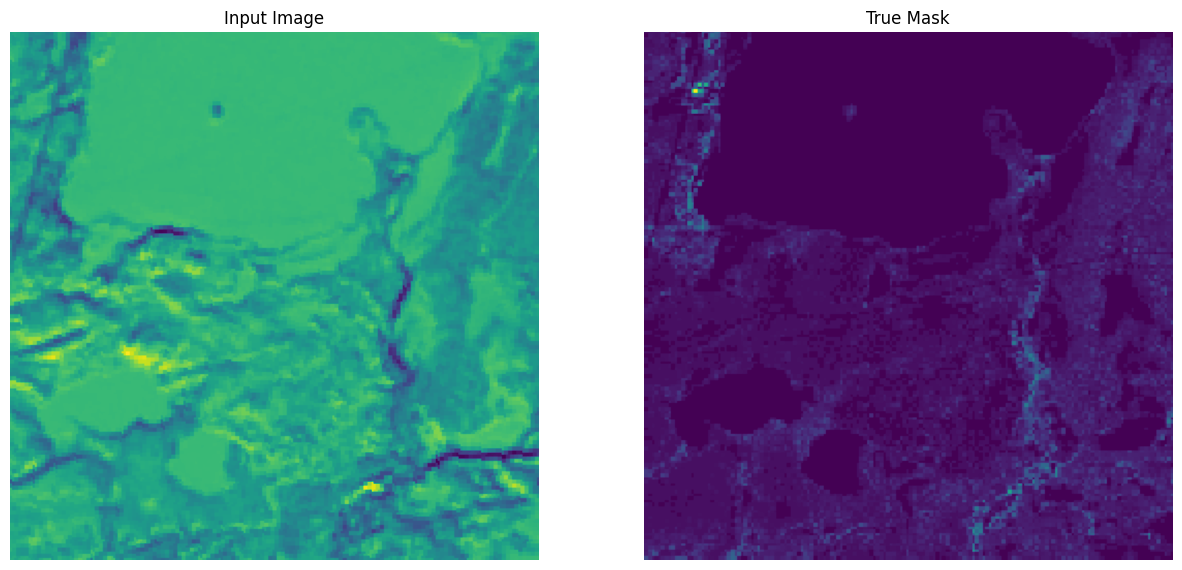

In [9]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(
            tf.transpose(display_list[i], perm=(2, 0, 1)).numpy()[3] # third band
            if i == 0 else display_list[i]
        )
        plt.axis("off")
    plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## Create model

In [10]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(
        n_filters, 
        3, 
        padding="same", 
        activation="relu", 
        kernel_initializer="he_normal"
    )(x)
    
    # Conv2D then ReLU activation
    x = layers.Conv2D(
        n_filters, 
        3, 
        padding="same", 
        activation="relu", 
        kernel_initializer="he_normal"
    )(x)
    
    return x

In [11]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [12]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(
        n_filters, 
        3, 
        2, 
        padding="same"
    )(x)
    
    # concatenate
    x = layers.concatenate([x, conv_features])
    
    # dropout
    x = layers.Dropout(0.3)(x)
    
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    
    return x

In [13]:
def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(256, 256, 11))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    # outputs = layers.Conv2D(256, 256, padding="same", activation="softmax")(u9)
    outputs = layers.Conv2D(1, 1, padding="same", activation="linear")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

## Train model

In [14]:
# compile model

unet_model = build_unet_model()

unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    # loss="mse",
    # metrics="mse",
    
    loss="MeanSquaredError",
    metrics="RootMeanSquaredError",
)

In [15]:
%%time

NUM_EPOCHS = 20
TRAIN_LENGTH = CHIPS_TO_SELECT_CNT - BATCH_SIZE
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
# VAL_SUBSPLITS = 5
# TEST_LENTH = info.splits["test"].num_examples
# VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = 2

model_history = unet_model.fit(
    train_batches,
    epochs=NUM_EPOCHS,
    # steps_per_epoch=2,
    steps_per_epoch=STEPS_PER_EPOCH,
    # validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    verbose=True,
)

Epoch 1/20
9/9 [==============================] - 87s 10s/step - loss: 13051459.0000 - root_mean_squared_error: 3612.6804 - val_loss: 67631.7031 - val_root_mean_squared_error: 260.0610
Epoch 2/20
9/9 [==============================] - 86s 10s/step - loss: 167391.9844 - root_mean_squared_error: 409.1357 - val_loss: 31592.1680 - val_root_mean_squared_error: 177.7419
Epoch 3/20
9/9 [==============================] - 85s 9s/step - loss: 71402.8281 - root_mean_squared_error: 267.2131 - val_loss: 17061.6680 - val_root_mean_squared_error: 130.6203
Epoch 4/20
9/9 [==============================] - 85s 10s/step - loss: 29136.2441 - root_mean_squared_error: 170.6934 - val_loss: 13277.1973 - val_root_mean_squared_error: 115.2267
Epoch 5/20
9/9 [==============================] - 85s 9s/step - loss: 13884.8975 - root_mean_squared_error: 117.8342 - val_loss: 7984.3291 - val_root_mean_squared_error: 89.3551
Epoch 6/20
9/9 [==============================] - 85s 9s/step - loss: 6883.0015 - root_mean_sq

## Check model results

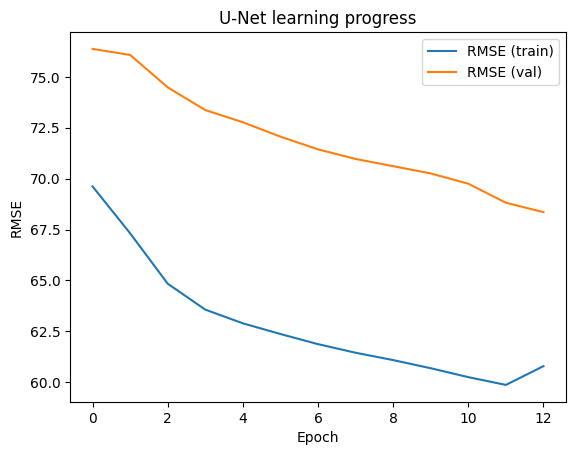

In [16]:
ax = (
    pd.DataFrame({
        # "loss": model_history.history["loss"],
        # "val_loss": model_history.history["val_loss"], 
        "RMSE (train)": model_history.history["root_mean_squared_error"][7:],
        "RMSE (val)": model_history.history["val_root_mean_squared_error"][7:],
    })
    .plot(
        title="U-Net learning progress"
    )
)

ax.set_xlabel("Epoch")
ax.set_ylabel("RMSE")

plt.show()

1/1 [==============================] - 3s 3s/step


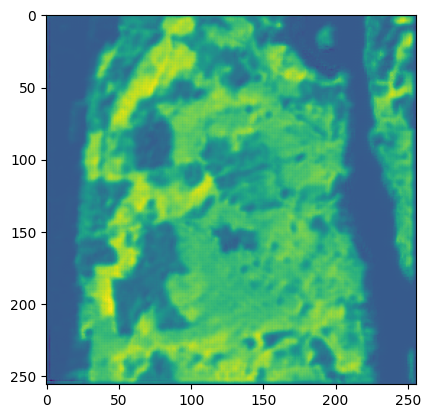

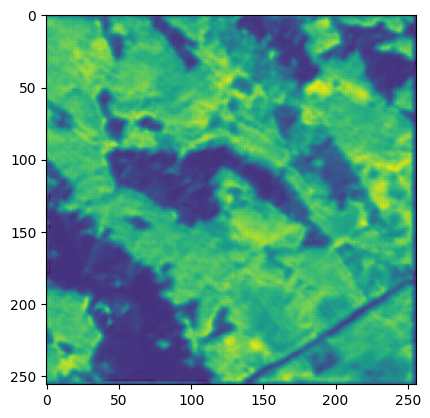

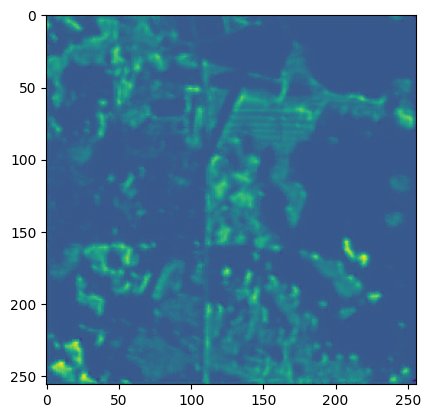

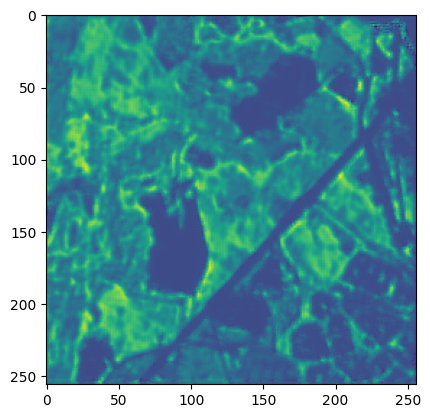

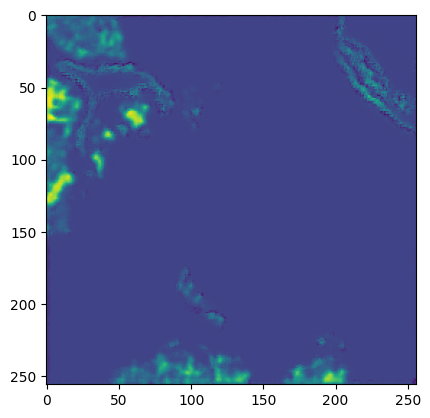

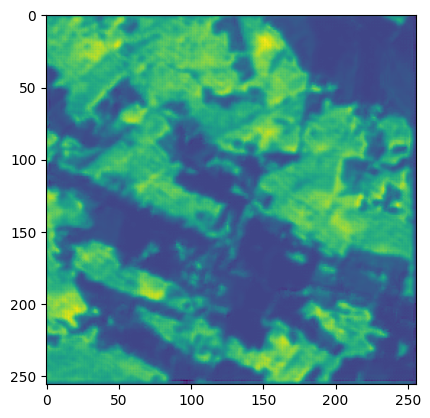

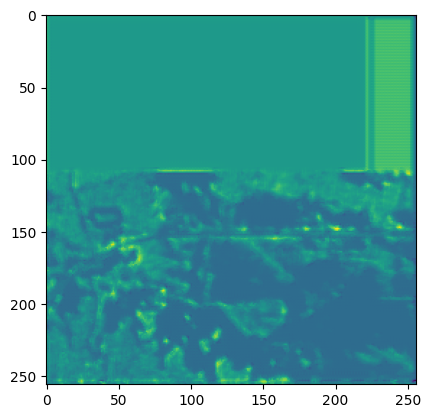

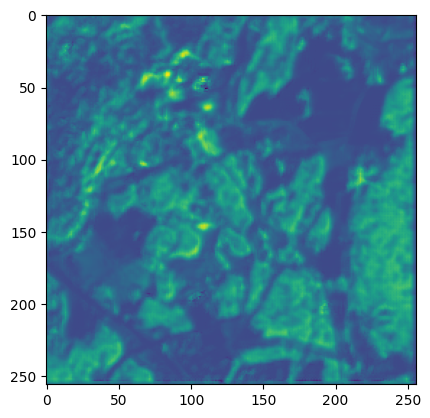

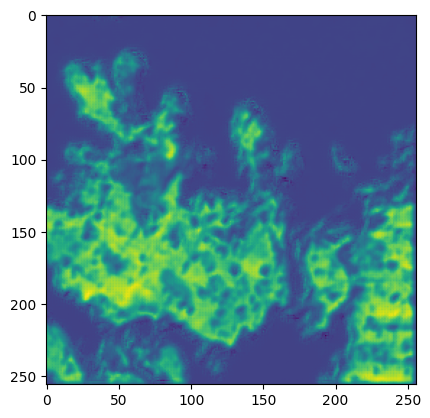

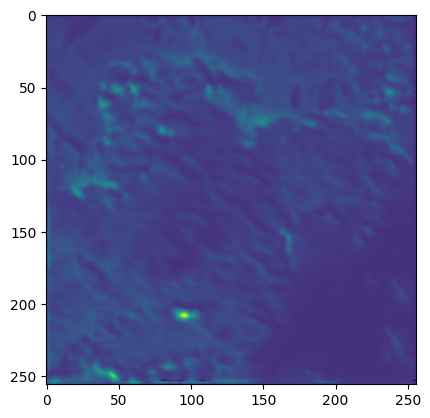

In [17]:
test_results = unet_model.predict(
    test_batches
)

for res in test_results:
    plt.imshow(res)
    plt.show()

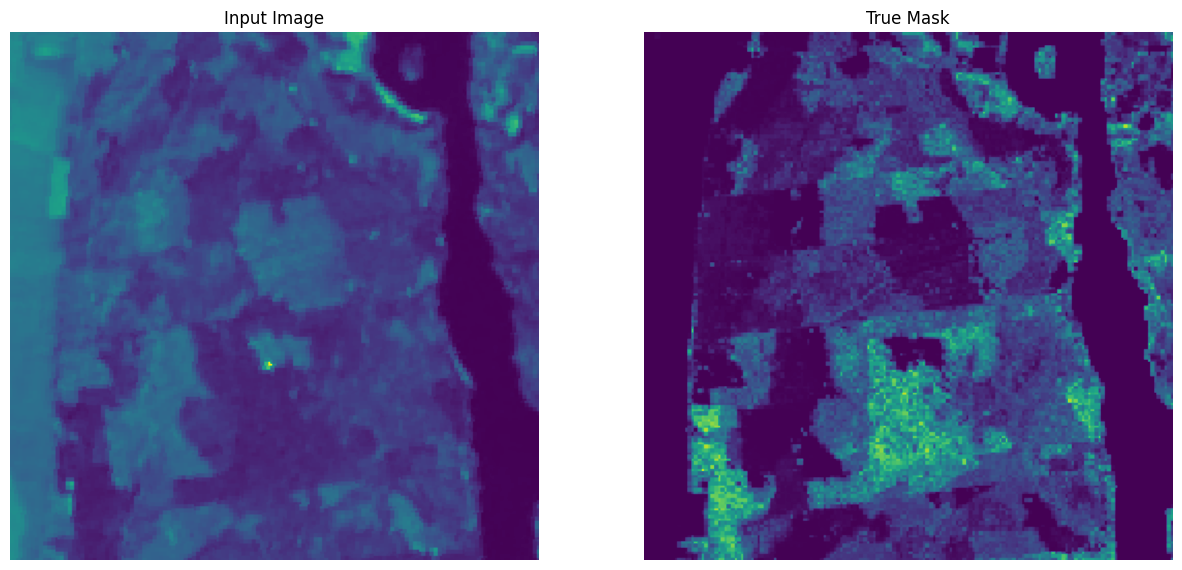

In [18]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

## Create submission

In [19]:
df_metadata = pd.read_csv(FEATURES_METADATA_PROCESSED_FILEPATH)

# filter metadata
df_metadata = (
    df_metadata
    .loc[
        (df_metadata.month == "April") &
        (df_metadata.satellite == "S2") &
        (df_metadata.split == "test")
    ]
    .reset_index(drop=True)
)

# df_metadata["satellite_cnt_per_chip_month"] = (
#     df_metadata
#     .groupby(["chip_id", "month"])
#     .satellite
#     .transform("count")
# )

df_metadata.tail()

,filename,filepath,label_filename,label_filepath,chip_id,satellite,split,month
2768,ff9dfc68_S2_07.tif,/usr/src/app/data/test_features/ff9dfc68_S2_07...,ff9dfc68_agbm.tif,/usr/src/app/data/test_agbm/ff9dfc68_agbm.tif,ff9dfc68,S2,test,April
2769,ffda6cc9_S2_07.tif,/usr/src/app/data/test_features/ffda6cc9_S2_07...,ffda6cc9_agbm.tif,/usr/src/app/data/test_agbm/ffda6cc9_agbm.tif,ffda6cc9,S2,test,April
2770,ffde1ed8_S2_07.tif,/usr/src/app/data/test_features/ffde1ed8_S2_07...,ffde1ed8_agbm.tif,/usr/src/app/data/test_agbm/ffde1ed8_agbm.tif,ffde1ed8,S2,test,April
2771,ffdfa26a_S2_07.tif,/usr/src/app/data/test_features/ffdfa26a_S2_07...,ffdfa26a_agbm.tif,/usr/src/app/data/test_agbm/ffdfa26a_agbm.tif,ffdfa26a,S2,test,April
2772,fff812c0_S2_07.tif,/usr/src/app/data/test_features/fff812c0_S2_07...,fff812c0_agbm.tif,/usr/src/app/data/test_agbm/fff812c0_agbm.tif,fff812c0,S2,test,April


In [20]:
%%time

# predictions mean

for i, row in df_metadata.iterrows():
    
    # read filepath and label filepath
    filepath = row["filepath"]
    label_filepath = row["label_filepath"]
    
    pred = unet_model.predict(
        tiff.imread(filepath).reshape(1, 256, 256, 11),
        verbose=False,
    )
    
    # save predictions
    tiff.imwrite(
        label_filepath, 
        data=(
            pred[0]
            .reshape(256, 256)
            .astype(np.float32) 
        )
    )
    
    if (i % 100 == 0) & (i != 0):
        print(f"--> finished prediciton of {i:,} tifs")

--> finished prediciton of 100 tifs
--> finished prediciton of 200 tifs
--> finished prediciton of 300 tifs
--> finished prediciton of 400 tifs
--> finished prediciton of 500 tifs
--> finished prediciton of 600 tifs
--> finished prediciton of 700 tifs
--> finished prediciton of 800 tifs
--> finished prediciton of 900 tifs
--> finished prediciton of 1,000 tifs
--> finished prediciton of 1,100 tifs
--> finished prediciton of 1,200 tifs
--> finished prediciton of 1,300 tifs
--> finished prediciton of 1,400 tifs
--> finished prediciton of 1,500 tifs
--> finished prediciton of 1,600 tifs
--> finished prediciton of 1,700 tifs
--> finished prediciton of 1,800 tifs
--> finished prediciton of 1,900 tifs
--> finished prediciton of 2,000 tifs
--> finished prediciton of 2,100 tifs
--> finished prediciton of 2,200 tifs
--> finished prediciton of 2,300 tifs
--> finished prediciton of 2,400 tifs
--> finished prediciton of 2,500 tifs
--> finished prediciton of 2,600 tifs
--> finished prediciton of 2,7

## Results

- The following submissions have been made. 
    - Model 8 (U-net v1)
        - Model has been trained on data subset (1 month, 90 chips per month).
        - Model has been tested on 10 chips.
        - Average RMSE equal to 58.5.
    - Model 9 (U-net without clouds)
        - Model has been trained on data subset (1 month, 90 chips per month).
        - Model has been tested on 10 chips.
        - Average RMSE equal to 61.8.
    - Model 10 (U-net with clouds, the same chips as Model 9)
        - Model has been trained on data subset (1 month, 90 chips per month).
        - Model has been tested on 10 chips.
        - Average RMSE equal to 56.1.

*Yes, the results don't make very much the sense.*